# CrowdFlower recipe ratings EDA

Issue: [calzone#136](https://github.com/cephalo-ai/calzone/issues/136)

This notebook looks at data from two CrowdFlower jobs ([report 1](https://make.crowdflower.com/jobs/995086/reports) & [report 2](https://make.crowdflower.com/jobs/994077/reports)) asking the question “Does this recipe look appealing?” given a recipe photo and title. The motivation behind this question is the assumption that the appealingness of a recipe image is a factor in deciding if the recipe itself is appealing. This, by extension, is a factor in whether the homechef decides to select the recipe for ingredient fullfillment and to cook.

The primary goal of this EDA is to validate the assumption that recipe source (domain) is a good proxy for image appeal and by extension image quality — ie appealing and high quality images generally come from certain sources. 

### Data
Both CSVs can be found in: kadaif.getwellio.com/kadaif/datasets/search/relevance
- [cf_report_995086_full.csv](https://console.cloud.google.com/storage/browser/kadaif.getwellio.com/kadaif/datasets/search/relevance/?project=wellio-kadaif&authuser=0&organizationId=885565850796/)
- [  cf_report_994077_full.csv](https://console.cloud.google.com/storage/browser/kadaif.getwellio.com/kadaif/datasets/search/relevance/?project=wellio-kadaif&authuser=0&organizationId=885565850796/)

Each row represents a rating for one recipe image/title. Each image/title is rated by a minimum of three different raters.

### Conclusions
Based on the analysis below, it's inconclusive whether domain is a good proxy for image appeal and quality. We need more data — many of the domains from the CrowdFlower job only have one recipe associated with them, additionally having quorum on image appeal being greater than three ratings (as well as having each recipe have the same number of ratings) would help develop more definitive conclusions.   

Another factor is the role of personal preference and taste when evaluating the appeal of recipe images. Someone might rate a recipe image as unappealing even though it may have elements of a more objectively high quality image simply because the person evaluating the image doesn't like a certain ingredient used in the recipe. A related (but unvalidated) observation is it seems as though "unhealthy" recipe images, for example of burgers, pizza, etc, are more often rated as appealing as opposed to images of vegetables and salads. There is also the issue of foods that inherently don't photograph as well as others (for example, soup).

That being said, on an intuitive level from simply browsing some of the recipe sources looked at in this analysis, it's clear some domains do indeed have more appealing, higher quality recipe photos. For example, [epicurious.com](https://www.epicurious.com/) has higher quality images than [food.com](www.food.com). On the other hand, [bettycrocker.com](https://www.bettycrocker.com/) recipes were rated higher than epicurious' recipes but I personally don't agree. In short, I think the best approach to finding domains that have high quality recipe images (to potentially use as labeled data in the future) is to "hand" curate a list of such domains.

## Load data
Combine both CF jobs into one dataframe.

In [1]:
import json
import requests
from urlparse import urlsplit

from IPython.display import display
import numpy as np
import pandas as pd
from PIL import Image, ImageStat
from StringIO import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
cf_1 = pd.read_csv('../data/cf_report_995086_full.csv')
cf_2 = pd.read_csv('../data/cf_report_994077_full.csv')

cf_raw = pd.concat([cf_1, cf_2])
cf_raw.head(2)

,does_this_recipe_look_appealing__ignoring_the_query,id,orig__created_at,orig__unit_id,query,recipe_id,recipe_image,recipe_link,recipe_title,relevance
0,"Yes, looks great",2409333282,NaN,NaN,Meals that take less than 20 mins to prepare a...,7e27b6a41094c897c98b5d18cdf02041,http://placehold.it/150x150?text=recipe,http://www.epicurious.com/recipes/member/views...,Pinwheels With a Crunchy Twist,1
1,"No, not appealing",2409333864,NaN,NaN,Meals that take less than 20 mins to prepare a...,7e27b6a41094c897c98b5d18cdf02041,http://placehold.it/150x150?text=recipe,http://www.epicurious.com/recipes/member/views...,Pinwheels With a Crunchy Twist,4


In [3]:
cf_raw.shape

(4320, 10)

## Data preprocessing
Binarize "does_this_recipe_look_appealing" column (0 = 'No, not appealing',1 = 'Yes, looks great') and create column for domain from recipe link.

In [4]:
cf_raw['appeal'] = cf_raw['does_this_recipe_look_appealing__ignoring_the_query'].str.contains('Yes') * 1

cf_raw['domain'] = cf_raw['recipe_link'].map(lambda x: "{0.netloc}".format(urlsplit(x.replace('www.', ''))))

cf = cf_raw[['id', 'recipe_id', 'recipe_image', 'recipe_link','recipe_title', 'relevance',
       'appeal', 'domain']]

cf.head(2)

,id,recipe_id,recipe_image,recipe_link,recipe_title,relevance,appeal,domain
0,2409333282,7e27b6a41094c897c98b5d18cdf02041,http://placehold.it/150x150?text=recipe,http://www.epicurious.com/recipes/member/views...,Pinwheels With a Crunchy Twist,1,1,epicurious.com
1,2409333864,7e27b6a41094c897c98b5d18cdf02041,http://placehold.it/150x150?text=recipe,http://www.epicurious.com/recipes/member/views...,Pinwheels With a Crunchy Twist,4,0,epicurious.com


In [5]:
cf.appeal.value_counts()

1    3643
0     677
Name: appeal, dtype: int64

## Most rated domains
Domains with the most ratings — these don't represent unique images, as each image is rated a minimum of three times, but rather multiple ratings of the same image to reach quorum.

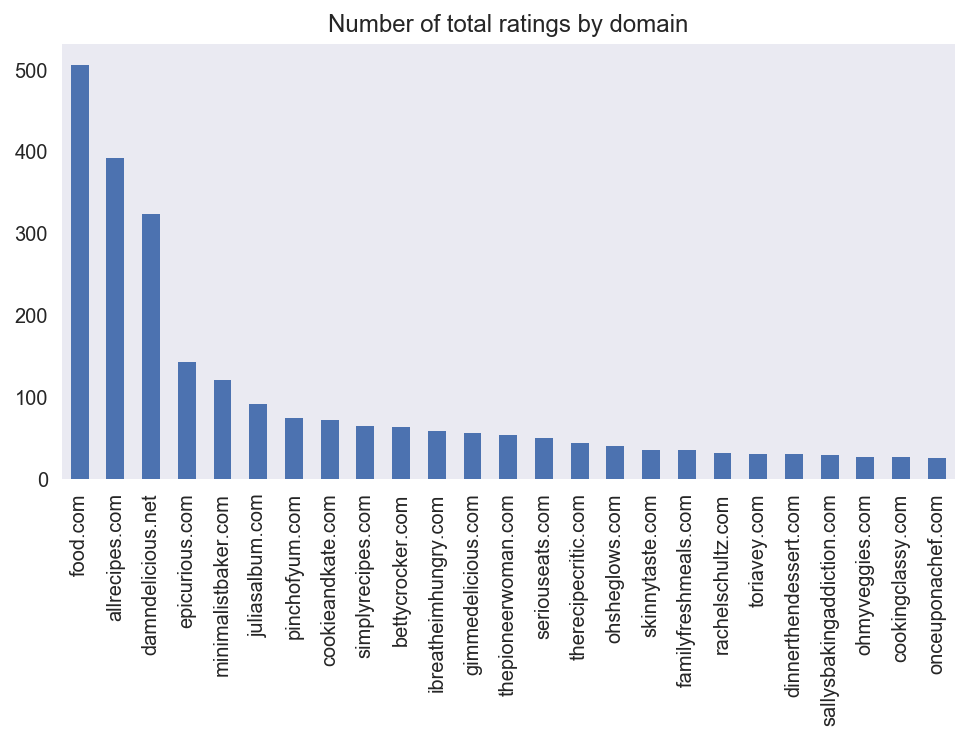

In [6]:
cf.domain.value_counts()[:25].plot.bar(figsize=(8,4)).set_title('Number of total ratings by domain');

In [7]:
cf.domain.value_counts(ascending=True).head()

somethingnewfordinner.com    3
livewellbakeoften.com        3
bobsredmill.com              3
nutmegnanny.com              3
iambaker.net                 3
Name: domain, dtype: int64

In [8]:
cf.domain.value_counts().shape

(354,)

## Mean rating by recipe image

Get the average appeal rating of a given recipe image.

In [9]:
img_agg_dict = {'appeal':'mean',
                'relevance': 'mean', 
                'recipe_image':'count'}

cf_img_mean = cf.groupby(['domain','recipe_image','recipe_link', 'recipe_title'])[['appeal', 'relevance']].agg(img_agg_dict)

cf_img_mean.columns = cf_img_mean.columns.get_level_values(0)
cf_img_mean.columns = ['relevance', 'appeal', 'total_img_ratings']
cf_img_mean.reset_index(inplace=True)

/Users/VanessaG/anaconda3/envs/wellio/lib/python2.7/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### Recipes with 5 or more ratings

In [10]:
cf_img_mean[cf_img_mean.total_img_ratings >= 5].sort_values(by='appeal', ascending=False).head()

,domain,recipe_image,recipe_link,recipe_title,relevance,appeal,total_img_ratings
426,food.com,http://pictures.food.com/api/file/cvYQ6WoQdW6S...,http://www.food.com/recipe/garlic-lemon-chicke...,Garlic & Lemon Chicken With Green Beans & Red ...,3.857143,1.0,7
616,momontimeout.com,http://www.momontimeout.com/wp-content/uploads...,http://www.momontimeout.com/2012/08/to-die-for...,To-Die-For Carrot Cake {Recipe},3.200000,1.0,10
557,laurafuentes.com,http://www.laurafuentes.com/wp-content/uploads...,http://www.laurafuentes.com/paleo-chili-recipe...,All Meat Veggie Chili {Paleo},3.200000,1.0,5
562,life-in-the-lofthouse.com,http://life-in-the-lofthouse.com/wp-content/up...,http://life-in-the-lofthouse.com/stuffed-frenc...,Stuffed French Bread,2.400000,1.0,5
245,dessertnowdinnerlater.com,http://www.dessertnowdinnerlater.com/wp-conten...,http://www.dessertnowdinnerlater.com/oreo-fudge/,Oreo Fudge,2.400000,1.0,5


In [11]:
cf_img_mean[cf_img_mean.total_img_ratings >= 5].shape

(329, 7)

### Display top recipe images 
With >= 5 total ratings per recipe and a rating of 1.0.

In [62]:
# doesn't han
def show_imgs(subset):
    try:
        for i in subset.index.values.tolist():
            response = requests.get(subset['recipe_image'][i])
            if response.status_code == 200:
                img = Image.open(StringIO(response.content))
                if img.width > 250:
                    new_w = 200
                    new_h = new_w * img.height / img.width
                    img = img.resize((new_w, new_h), Image.ANTIALIAS)
                    display(img)
                    print("average appeal: {0} | average relevance: {1} | total ratings: {2} | domain: {3} \n{4} \n{5}".\
                          format(subset['appeal'][i], subset['relevance'][i], subset['total_img_ratings'][i], 
                                  subset['domain'][i], subset['recipe_link'][i], subset['recipe_image'][i]))
                else:
                    display(img)
                    print("average appeal: {0} | average relevance: {1} | total ratings: {2} | domain: {3} \n{4} \n{5}".\
                          format(subset['appeal'][i], subset['relevance'][i], subset['total_img_ratings'][i], 
                                  subset['domain'][i], subset['recipe_link'][i], subset['recipe_image'][i]))
            else:
                pass
            
    except IOError as e:
        pass

def domain_recipe(domain, recipe):
    return cf_img_mean[(cf_img_mean.domain == domain) & (cf_img_mean.recipe_title == recipe)]

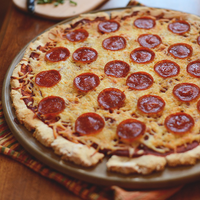

average appeal: 1.0 | average relevance: 4.0 | total ratings: 9 | domain: minimalistbaker.com 
http://minimalistbaker.com/the-best-gluten-free-pizza-crust-sauce/ 
http://cdn3.minimalistbaker.com/wp-content/uploads/2013/06/The-Best-Gluten-Free-Pizza-Dough-square.jpg


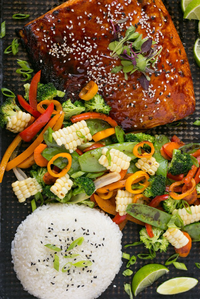

average appeal: 1.0 | average relevance: 4.0 | total ratings: 6 | domain: dinneratthezoo.com 
http://www.dinneratthezoo.com/hoisin-lime-glazed-salmon-with-mixed-vegetables/ 
http://www.dinneratthezoo.com/wp-content/uploads/2015/07/asian-salmon-41-683x1024.jpg


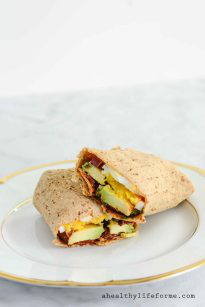

average appeal: 1.0 | average relevance: 4.0 | total ratings: 6 | domain: ahealthylifeforme.com 
http://ahealthylifeforme.com/egg-and-avocado-wrap-low-carb-high-protein/ 
https://i1.wp.com/ahealthylifeforme.com/wp-content/uploads/2015/05/Egg-and-Avocado-Wrap-Recipe-3.jpg?w=205


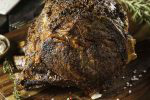

average appeal: 1.0 | average relevance: 2.4 | total ratings: 5 | domain: copykat.com 
http://www.copykat.com/2013/04/12/how-to-make-the-perfect-roast-beef/ 
http://www.copykat.com/wp-content/uploads/2016/12/How-to-Make-A-Roast-pin-150x100.jpg


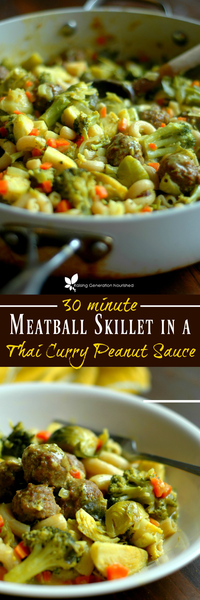

average appeal: 1.0 | average relevance: 3.2 | total ratings: 5 | domain: raisinggenerationnourished.com 
http://www.raisinggenerationnourished.com/2017/02/30-minute-meatball-skillet-curry-peanut-sauce/ 
http://www.raisinggenerationnourished.com/wp-content/uploads/2017/01/Pinterest-3.jpg


In [63]:
show_imgs(cf_img_mean[(cf_img_mean.total_img_ratings >= 5) & (cf_img_mean.appeal == 1.00)].sample(n=5).sort_values(by='total_img_ratings', ascending=False))

## Mean rating by domain
For each domain, take the average of the appeal ratings per recipe (which itself is an average) to get domain average.

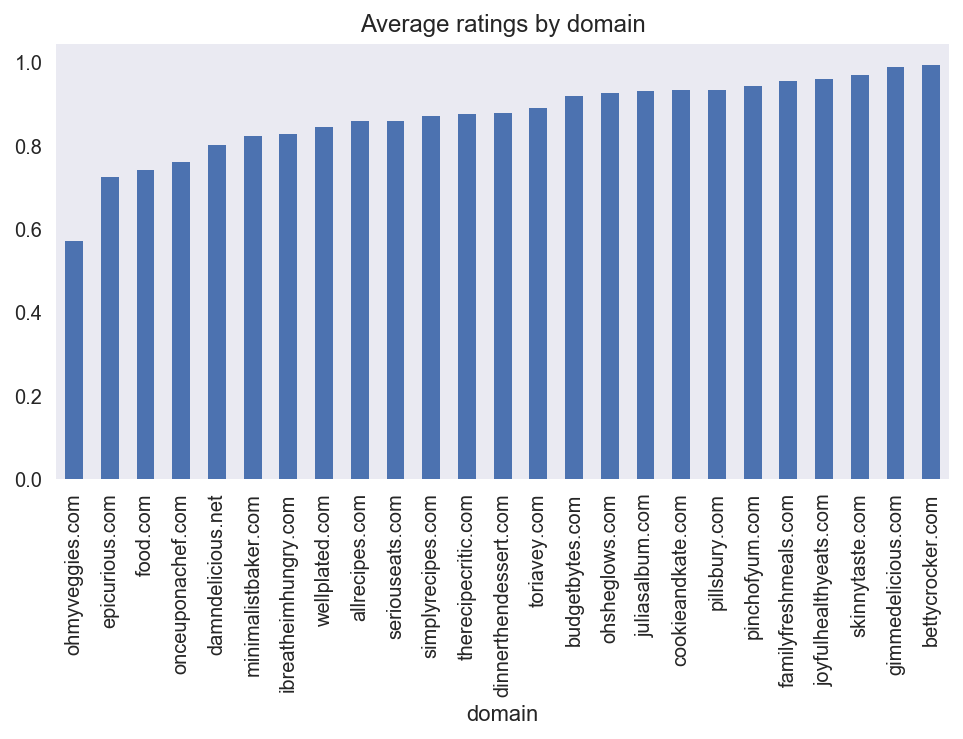

In [64]:
domain_agg_dict = {'appeal':'mean',
                   'relevance': 'mean',
                   'recipe_image':lambda img: img.drop_duplicates().count()}

cf_domain_mean = cf_img_mean.groupby('domain').agg(domain_agg_dict)
cf_domain_mean.columns = ['relevance', 'appeal', 'unique_imgs']
cf_domain_mean.reset_index(inplace=True)

cf_domain_mean[cf_domain_mean.unique_imgs >= 5].sort_values(by='appeal').plot.\
    bar(x='domain', y='appeal', figsize=(8,4), legend=False).set_title('Average ratings by domain');

In [65]:
cf_domain_mean.shape[0]

353

Checking a hunch that relevance and appeal are correlated, which they are slightly but I would expect more. I probably need to normalize relevance differently if I want to compare the two.

Jeff brings up a very valid point: "relevance is interpreted in terms of a given search query (which we're not looking at). The most appealing recipe in the world may still be not relevant to the query."

In [66]:
cf_domain_mean.corr()

,relevance,appeal,unique_imgs
relevance,1.000000,0.215991,-0.020416
appeal,0.215991,1.000000,0.006134
unique_imgs,-0.020416,0.006134,1.000000


###  Domains with high recipe ratings
bettycrocker.com, cookieandkate.com, pinchofyum.com are examples domains with high recipe ratings (>= 0.9) — lets see what these look like...

In [67]:
cf_domain_mean[(cf_domain_mean.appeal >= 0.9) & (cf_domain_mean.unique_imgs >= 5)].sort_values(by='unique_imgs', ascending=False).head(3)

,domain,relevance,appeal,unique_imgs
27,bettycrocker.com,3.633761,0.994872,15
50,cookieandkate.com,3.186744,0.933150,11
221,pinchofyum.com,3.121625,0.943074,11


#### bettycrocker.com

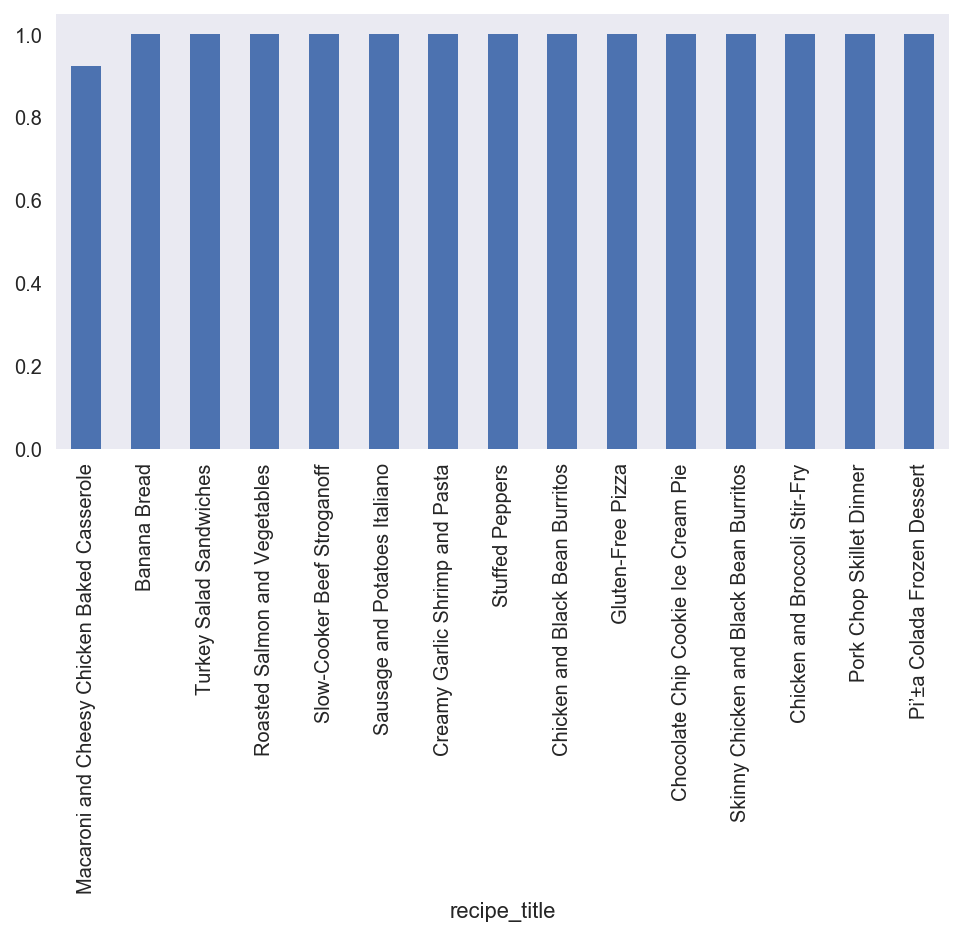

In [68]:
cf_img_mean[cf_img_mean.domain == 'bettycrocker.com'].sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', legend=False, figsize=(8,4)); 

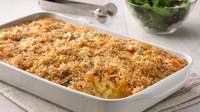

average appeal: 0.923076923077 | average relevance: 3.92307692308 | total ratings: 13 | domain: bettycrocker.com 
http://www.bettycrocker.com/recipes/macaroni-and-cheesy-chicken-baked-casserole/931d4b24-f9ba-49f1-9e17-2c0e516086b0 
http://images-gmi-pmc.edge-generalmills.com/8d2bd72d-e454-4c56-ad3f-7a7fb1633461.jpg


In [69]:
show_imgs(domain_recipe('bettycrocker.com', 'Macaroni and Cheesy Chicken Baked Casserole'))

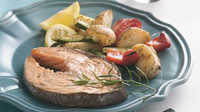

average appeal: 1.0 | average relevance: 4.0 | total ratings: 3 | domain: bettycrocker.com 
http://www.bettycrocker.com/recipes/roasted-salmon-and-vegetables/e0e31e80-dd4d-46b0-a2f8-50cd1ffcbb9b 
http://images-gmi-pmc.edge-generalmills.com/2d097c52-8737-4f1a-8579-002d07c29350.jpg


In [70]:
show_imgs(domain_recipe('bettycrocker.com', 'Roasted Salmon and Vegetables'))

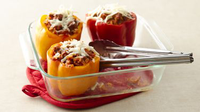

average appeal: 1.0 | average relevance: 2.66666666667 | total ratings: 3 | domain: bettycrocker.com 
http://www.bettycrocker.com/recipes/stuffed-peppers/63e29e18-903e-467c-aec5-fba4ce3a138f 
http://images-gmi-pmc.edge-generalmills.com/7d044231-1ad0-4e97-8010-788184920b30.jpg


In [71]:
show_imgs(domain_recipe('bettycrocker.com', 'Stuffed Peppers'))

#### cookieandkate.com
Interesting find — soup and chili recipes rated slightly lower, perhaps because these dishes inherently don't as photograph well.

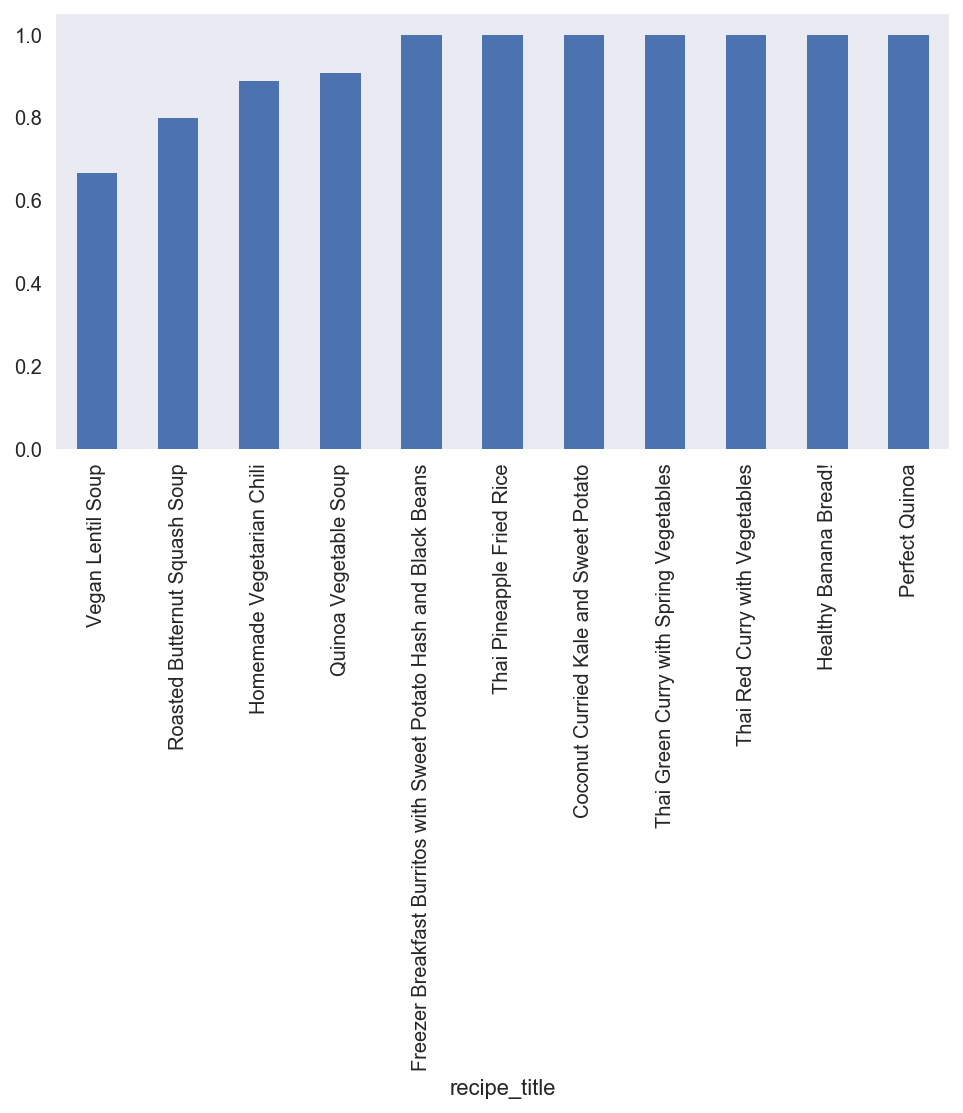

In [72]:
cf_img_mean[cf_img_mean.domain == 'cookieandkate.com'].sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', legend=False, figsize=(8,4));

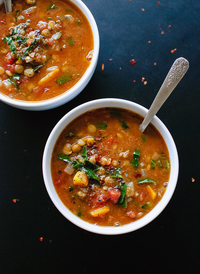

average appeal: 0.666666666667 | average relevance: 3.16666666667 | total ratings: 6 | domain: cookieandkate.com 
http://cookieandkate.com/2015/vegan-lentil-soup-recipe/ 
http://cookieandkate.com/images/2015/02/vegan-lentil-soup-recipe-2.jpg


In [73]:
show_imgs(domain_recipe('cookieandkate.com', 'Vegan Lentil Soup'))

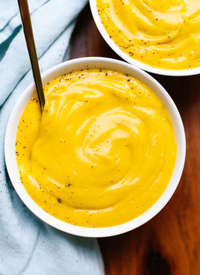

average appeal: 0.8 | average relevance: 2.8 | total ratings: 5 | domain: cookieandkate.com 
http://cookieandkate.com/2015/roasted-butternut-squash-soup/ 
http://cookieandkate.com/images/2015/11/roasted-butternut-squash-soup-270x372.jpg


In [74]:
show_imgs(domain_recipe('cookieandkate.com', 'Roasted Butternut Squash Soup'))

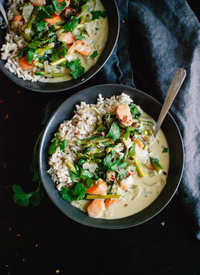

average appeal: 1.0 | average relevance: 3.71428571429 | total ratings: 7 | domain: cookieandkate.com 
http://cookieandkate.com/2015/thai-green-curry-with-spring-vegetables/ 
http://cookieandkate.com/images/2015/03/thai-green-curry-1-270x372.jpg


In [75]:
show_imgs(domain_recipe('cookieandkate.com', 'Thai Green Curry with Spring Vegetables'))

#### pinchofyum.com

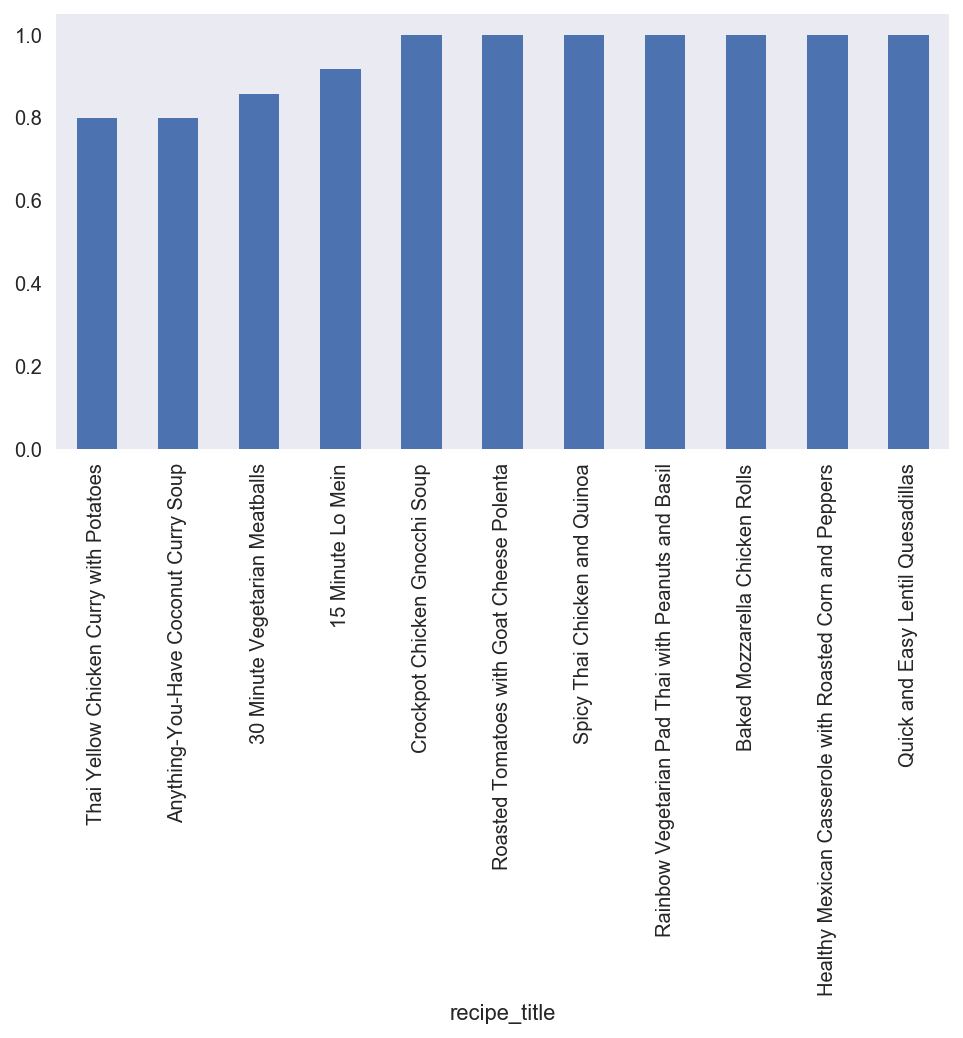

In [76]:
cf_img_mean[cf_img_mean.domain == 'pinchofyum.com'].sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', legend=False, figsize=(8,4));

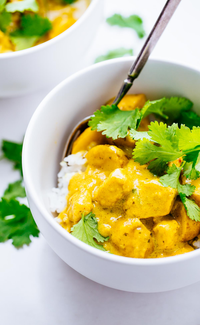

average appeal: 0.8 | average relevance: 3.2 | total ratings: 5 | domain: pinchofyum.com 
http://pinchofyum.com/thai-yellow-chicken-curry-with-potatoes 
http://cdn.pinchofyum.com/wp-content/uploads/Thai-Yellow-Chicken-Curry-1.jpg


In [77]:
show_imgs(domain_recipe('pinchofyum.com', 'Thai Yellow Chicken Curry with Potatoes'))

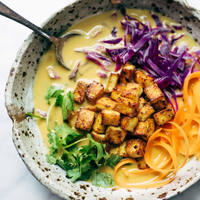

average appeal: 0.8 | average relevance: 3.0 | total ratings: 5 | domain: pinchofyum.com 
http://pinchofyum.com/anything-you-have-coconut-curry-soup 
http://cdn.pinchofyum.com/wp-content/uploads/Vegan-Coconut-Curry-Soup-Square.jpg


In [78]:
show_imgs(domain_recipe('pinchofyum.com', 'Anything-You-Have Coconut Curry Soup'))

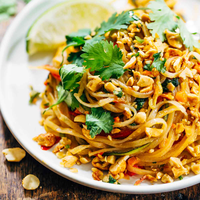

average appeal: 1.0 | average relevance: 3.64285714286 | total ratings: 14 | domain: pinchofyum.com 
http://pinchofyum.com/rainbow-vegetarian-pad-thai-with-peanuts-and-basil 
http://cdn.pinchofyum.com/wp-content/uploads/Vegetarian-Pad-Tha-2-2-Square.jpg


In [79]:
show_imgs(domain_recipe('pinchofyum.com', 'Rainbow Vegetarian Pad Thai with Peanuts and Basil'))

###  Domains with mediocre recipes ratings 
ohmyveggies.com, epicurious.com, food.com are examples domains with mediocre recipe ratings (0.55 - 0.75) — lets see what these look like...

In [80]:
cf_domain_mean[(cf_domain_mean.appeal >= 0.5) & (cf_domain_mean.unique_imgs >= 5)].sort_values(by='appeal').head()

,domain,relevance,appeal,unique_imgs
207,ohmyveggies.com,3.285714,0.572619,5
87,epicurious.com,3.333269,0.726512,20
99,food.com,2.766755,0.741435,96
209,onceuponachef.com,3.592857,0.761905,7
62,damndelicious.net,2.882735,0.801376,32


#### ohmyveggies.com

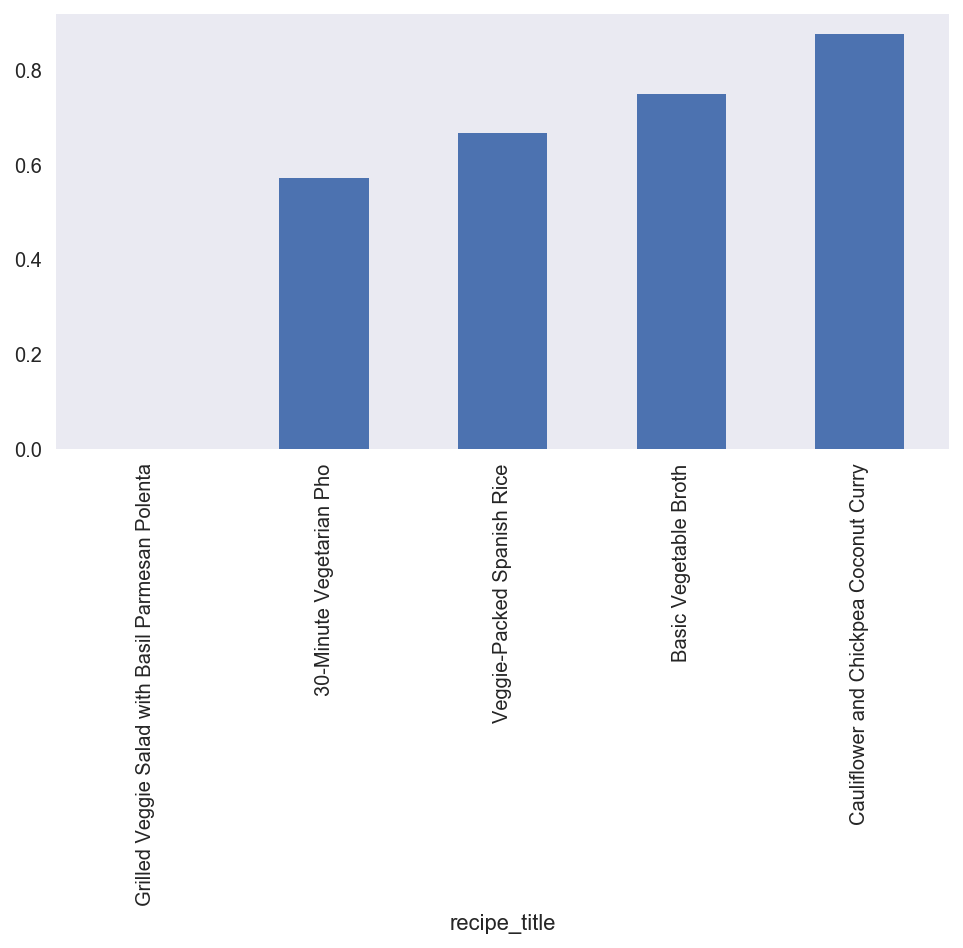

In [81]:
cf_img_mean[cf_img_mean.domain == 'ohmyveggies.com'].sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', legend=False, figsize=(8,4));

Zero rated image from ohmyveggies.com — interestingly it's a salad:

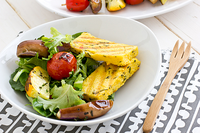

average appeal: 0.0 | average relevance: 2.5 | total ratings: 4 | domain: ohmyveggies.com 
http://ohmyveggies.com/recipe-grilled-veggie-salad-with-basil-parmesan-polenta/ 
http://ohmyveggies.com/wp-content/uploads/2012/08/grilled_veggie_salad_with_parmesan_polenta_recipe.jpg


In [82]:
show_imgs(domain_recipe('ohmyveggies.com', 'Grilled Veggie Salad with Basil Parmesan Polenta'))

Slightly above average rated image from ohmyveggies.com:

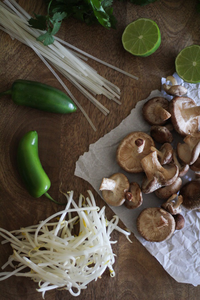

average appeal: 0.571428571429 | average relevance: 2.42857142857 | total ratings: 7 | domain: ohmyveggies.com 
http://ohmyveggies.com/30-minute-vegetarian-pho/ 
http://ohmyveggies.com/wp-content/uploads/2014/04/pho-soup-with-sauteed-shiitake-mushrooms-2.jpg


In [83]:
show_imgs(domain_recipe('ohmyveggies.com', '30-Minute Vegetarian Pho'))

Top rated image from ohmyveggies.com:

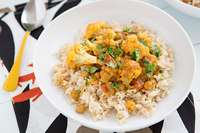

average appeal: 0.875 | average relevance: 3.75 | total ratings: 8 | domain: ohmyveggies.com 
http://ohmyveggies.com/recipe-cauliflower-chickpea-coconut-curry/ 
http://ohmyveggies.com/wp-content/uploads/2013/11/cauliflower_and_chickpea_coconut_curry_recipe.jpg


In [84]:
show_imgs(domain_recipe('ohmyveggies.com', 'Cauliflower and Chickpea Coconut Curry'))

#### epicurious.com
A high proportion of recipes from epicurious.com had no image so I assume the placeholder image was shown to the raters (and the corresponding recipes were not surprisingly rated poorly). From a purely visual assessment, images from epicurious.com do appear to be high quality and professional looking despite getting a mediocre rating overall. Another interesting finding to note — some of the highest rated recipes are 'burgers', 'fried chicken', 'pizza', and 'chocolate cake' (in other words, unhealthy food).

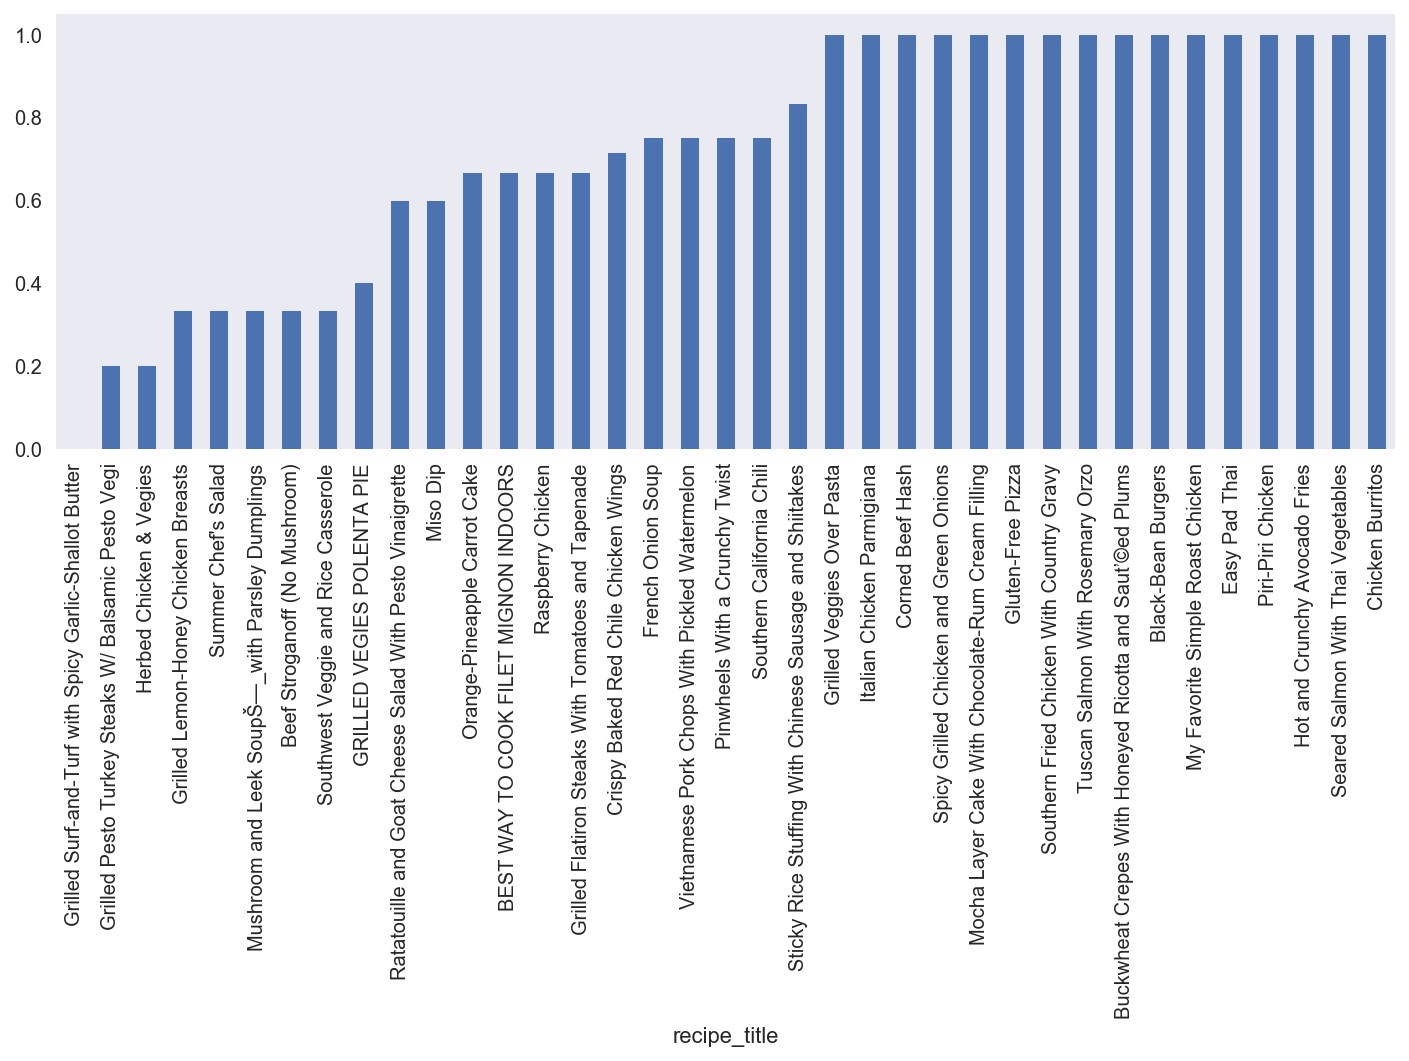

In [85]:
cf_img_mean[cf_img_mean.domain == 'epicurious.com'].sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', figsize=(12,4), legend=False);

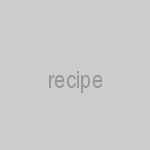

average appeal: 0.0 | average relevance: 4.0 | total ratings: 3 | domain: epicurious.com 
http://www.epicurious.com/recipes/food/views/grilled-surf-and-turf-with-spicy-garlic-shallot-butter-105300 
http://placehold.it/150x150?text=recipe


In [86]:
show_imgs(domain_recipe('epicurious.com','Grilled Surf-and-Turf with Spicy Garlic-Shallot Butter'))

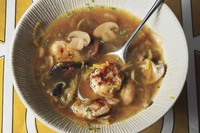

average appeal: 0.333333333333 | average relevance: 1.0 | total ratings: 3 | domain: epicurious.com 
http://www.epicurious.com/recipes/food/views/mushroom-and-leek-soup-with-parsley-dumplings-357310 
http://assets.epicurious.com/photos/54b3b4a321388ef838b0ac97/6:4/w_620%2Ch_413/357310_mushroom-leek-soup_1x1.jpg


In [87]:
show_imgs(domain_recipe('epicurious.com','Mushroom and Leek SoupŠ—_with Parsley Dumplings'))

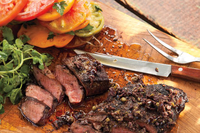

average appeal: 0.666666666667 | average relevance: 4.0 | total ratings: 3 | domain: epicurious.com 
http://www.epicurious.com/recipes/food/views/grilled-flatiron-steaks-with-tomatoes-and-tapenade-395897 
http://assets.epicurious.com/photos/54b0b4811cc76a014cfaef22/6:4/w_620%2Ch_413/395897_grilled-flatiron-steaks_1x1.jpg


In [88]:
show_imgs(domain_recipe('epicurious.com','Grilled Flatiron Steaks With Tomatoes and Tapenade'))

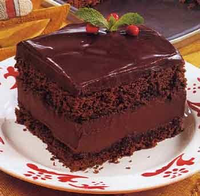

average appeal: 1.0 | average relevance: 1.8 | total ratings: 5 | domain: epicurious.com 
http://www.epicurious.com/recipes/food/views/mocha-layer-cake-with-chocolate-rum-cream-filling-106023 
http://assets.epicurious.com/photos/560ea8b0f3a00aeb2f1d72a9/master/pass/106023.jpg


In [89]:
show_imgs(domain_recipe('epicurious.com','Mocha Layer Cake With Chocolate-Rum Cream Filling'))

#### food.com
Similar to epicurious.com, food.com has a good amount of recipes with no recipe image that use the generic placeholder image instead. This again also likely negatively impacted raters ratings of recipes in terms of appeal. However, again, just from a purely visual assessement food.com image quality is not good and the photographic style is amateurish looking.

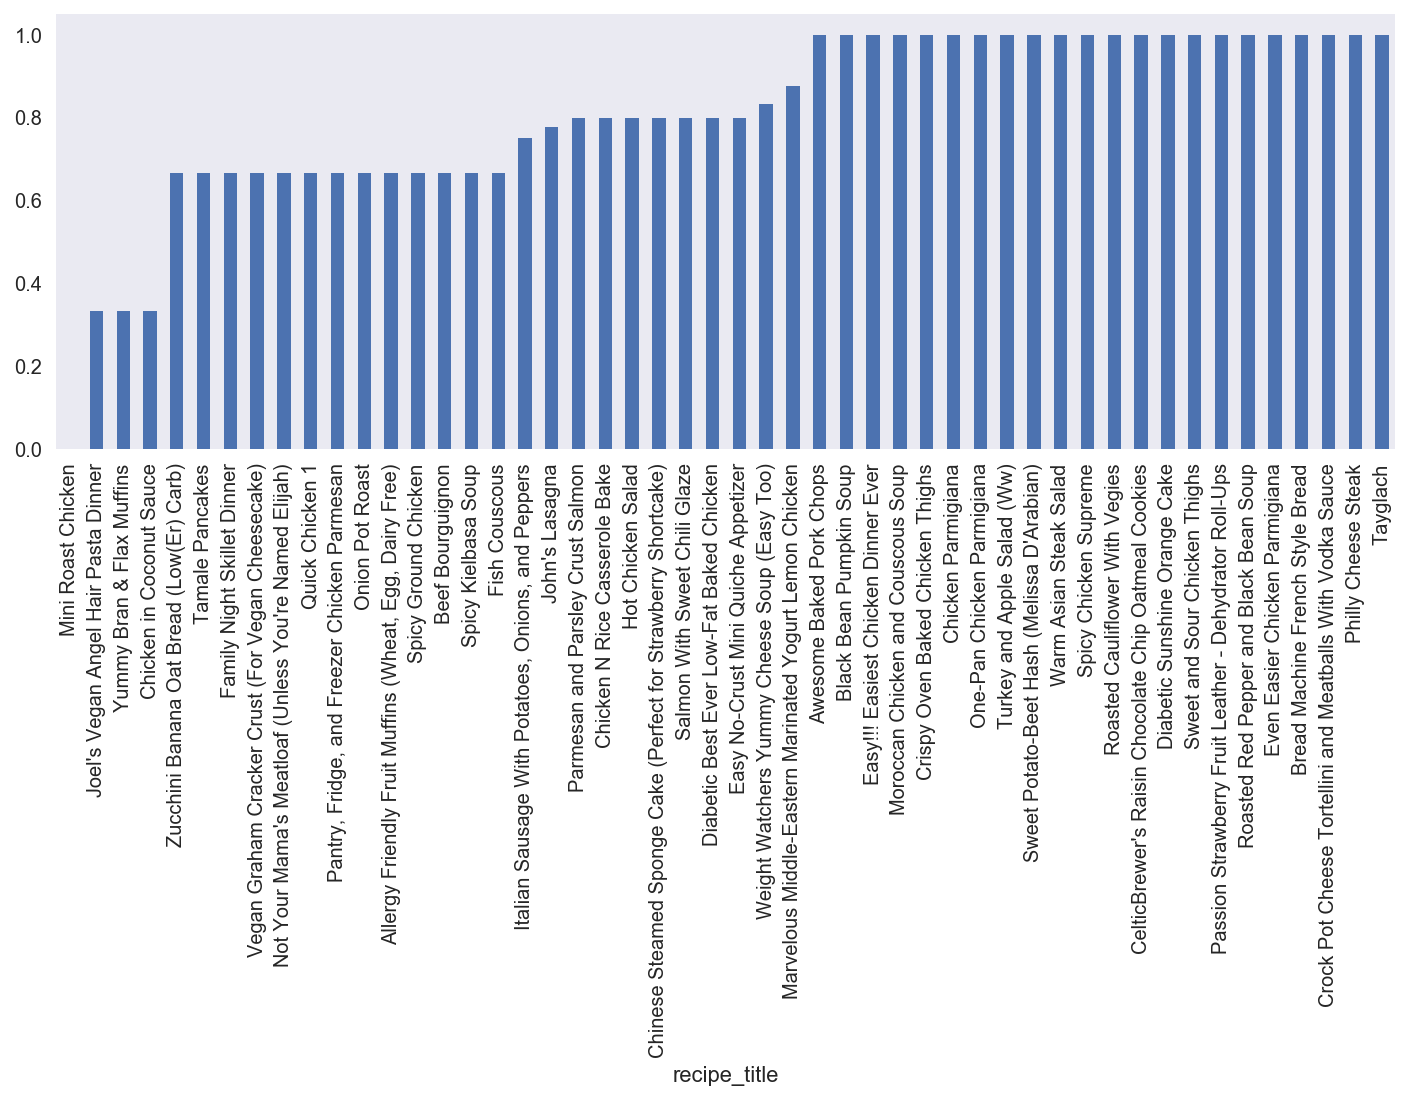

In [90]:
cf_img_mean[cf_img_mean.domain == 'food.com'].sample(n=50).sort_values(by='appeal')\
    .plot.bar(x='recipe_title', y='appeal', figsize=(12,4), legend=False);

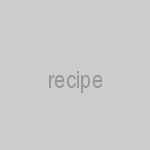

average appeal: 0.0 | average relevance: 1.0 | total ratings: 3 | domain: food.com 
http://www.food.com/recipe/flirtini-171614 
http://placehold.it/150x150?text=recipe


In [91]:
show_imgs(domain_recipe('food.com','Flirtini'))

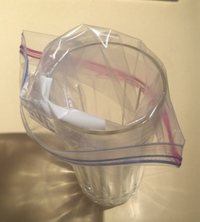

average appeal: 0.333333333333 | average relevance: 2.0 | total ratings: 3 | domain: food.com 
http://www.food.com/recipe/grilled-portabella-sammies-sandwiches-with-onion-marmalade-305228 
http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/30/52/28/piczrvjNr.jpg


In [92]:
show_imgs(domain_recipe('food.com','Grilled Portabella Sammies/Sandwiches With Onion Marmalade'))

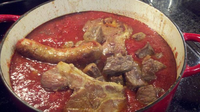

average appeal: 0.6 | average relevance: 1.4 | total ratings: 5 | domain: food.com 
http://www.food.com/recipe/sopranos-sunday-gravy-spaghetti-sauce-64750 
http://img.sndimg.com/food/image/upload/w_614,h_461,c_fit/v1/img/recipes/64/75/0/picmVc9xx.jpg


In [93]:
show_imgs(domain_recipe('food.com',"Soprano's Sunday Gravy (Spaghetti Sauce)"))

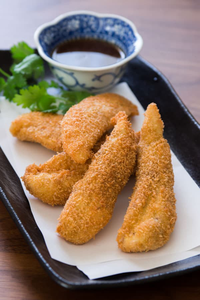

average appeal: 1.0 | average relevance: 2.2 | total ratings: 5 | domain: food.com 
http://www.food.com/recipe/fried-chicken-fingers-tenders-334473 
http://a.ctimg.net/jBDFizSLQjqtV3RVmCEIlg/recipecoconut-chicken-fingers.1024x1024.jpg


In [94]:
show_imgs(domain_recipe('food.com','Fried Chicken Fingers (Tenders)'))

###  Domains with very low recipe ratings
Domains rated 0.5 or lower — difficult to draw any conclusions here as many of the domains have only one recipe associated with them.

In [95]:
cf_domain_mean[cf_domain_mean.appeal <= 0.5].sort_values(by='appeal')

,domain,relevance,appeal,unique_imgs
83,eatingvibrantly.com,1.000000,0.000000,1
273,studiobotanica.com,3.250000,0.250000,1
77,dvo.com,2.250000,0.250000,1
3,acultivatednest.com,3.333333,0.333333,1
241,scratchinit.halversen.com,2.000000,0.333333,1
202,norecipes.com,1.958333,0.333333,2
185,momadvice.com,4.000000,0.333333,1
171,littlekitchenbigworld.com,4.000000,0.333333,1
337,veggieinspiredjourney.com,3.000000,0.333333,1
142,jeanetteshealthyliving.com,1.000000,0.333333,1


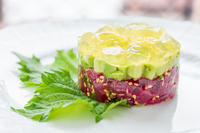

average appeal: 0.0 | average relevance: 1.25 | total ratings: 4 | domain: norecipes.com 
http://norecipes.com/recipe/tuna-tartare-with-yuzu-gelee 
http://a.ctimg.net/fdffM7mqSl20h0TkNFBqlA/recipetuna-tartare-with-yuzu-gelee.1024x1024.jpg


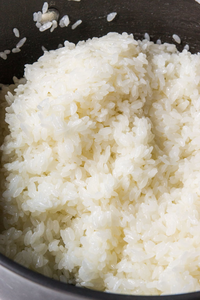

average appeal: 0.666666666667 | average relevance: 2.66666666667 | total ratings: 3 | domain: norecipes.com 
http://norecipes.com/recipe/sushi-rice-recipe 
http://a.ctimg.net/t_yrmlx0QQaDt2CdaanZ8g/recipesushi-rice-recipe.1024x1024.jpg


In [96]:
show_imgs(cf_img_mean[cf_img_mean.domain == 'norecipes.com'].sort_values(by='appeal'))

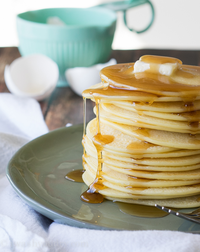

average appeal: 0.666666666667 | average relevance: 4.0 | total ratings: 3 | domain: iwashyoudry.com 
http://www.iwashyoudry.com/2015/02/11/dads-3-ingredient-pancakes/ 
http://www.iwashyoudry.com/wp-content/uploads/2015/02/Dads-3-Ingredient-Pancakes-5.jpg


In [98]:
show_imgs(cf_img_mean[cf_img_mean.domain == 'iwashyoudry.com'].sort_values(by='appeal'))

###  Below I spot check recipe titles
Just curious how appealing recipes with certain words in the title (ie burger, chicken, pizza) were rated. I create a new column for the titles in lower case to catch all appearances of the word.

In [99]:
cf_img_mean['recipe_title_lc'] = cf_img_mean['recipe_title'].map(lambda x: x.lower())

In [102]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('hamburger|burger')]['appeal'].mean()

0.75555555555555554

In [103]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('chicken')]['appeal'].mean()

0.86829959639712739

In [104]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('pizza')]['appeal'].mean()

0.8930555555555556

In [105]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('chocolate')]['appeal'].mean()

0.88300000000000001

In [106]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('salad')]['appeal'].mean()

0.80187499999999989

In [107]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('fast')]['appeal'].mean()

0.85666666666666669

In [108]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('fries')]['appeal'].mean()

1.0

In [109]:
cf_img_mean[cf_img_mean.recipe_title_lc.str.contains('salmon')]['appeal'].mean()

0.93129084967320264

# Social media scores for recipes

Taking a peek at social media scores for recipes. Though this data isn't recipe image specific, it could be interesting to see how it stacks up with the findings for domain and appeal ratings from the above analysis.  

### Data 
Can be found [here](https://console.cloud.google.com/storage/browser/kadaif.getwellio.com/kadaif/datasets/recipes/social_media?project=wellio-kadaif&authuser=0&organizationId=885565850796). 

### Conclusions
The only domain that appears both in the top ten domains by recipe social media score and the top ten domains by recipe CF rater appeal is [juliasalbum.com](http://juliasalbum.com/) (I concur, the recipe images on this blog look nice). Any further conclusions require investigating actual recipe images. Just a quick glance at the top ten domains by social media scores, my assessments is that some domains have appealing/high quality images and some domains, not so much. For example, [rachelschultz.com](http://rachelschultz.com/) has nice images, whereas [mylifewellloved.com](http://mylifewellloved.com/) are not as good and the high social media score here may be more a reflection of this blog owner's skill at social media marketing.

In [61]:
social_scores = []
for line in open('../data/social_media.json', 'r'):
    social_scores.append(json.loads(line))

In [62]:
len(social_scores)

1181236

In [63]:
social_scores_df = pd.DataFrame(social_scores)
social_scores_df.head(3)

,item_id,item_kind,payload,score,social_media,url
0,f091e108eae72754fc3d1ebeaccce087,recipe,"{""count"": 0, ""url"": ""http://www.food.com/recip...",0,Pinterest,http://www.food.com/recipe/gourmet-stuffed-egg...
1,548bc937bea6e983a47a9e5fca5735d9,recipe,"{""count"": 0, ""url"": ""http://www.food.com/recip...",0,Pinterest,http://www.food.com/recipe/stuffed-mushrooms-b...
2,70bb5d7c42382f04f9bb3ad15835a348,recipe,"{""id"": ""http://allrecipes.com/recipe/84912/wic...",1,FB,http://allrecipes.com/recipe/84912/wicked-good...


In [64]:
social_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181236 entries, 0 to 1181235
Data columns (total 6 columns):
item_id         1181236 non-null object
item_kind       1181236 non-null object
payload         979814 non-null object
score           979814 non-null object
social_media    979814 non-null object
url             1181236 non-null object
dtypes: object(6)
memory usage: 54.1+ MB


In [68]:
social_scores_df.item_kind.value_counts()

recipe    1181236
Name: item_kind, dtype: int64

In [69]:
social_scores_df.dropna(inplace=True)
social_scores_df['domain'] = social_scores_df['url'].map(lambda x: "{0.netloc}".format(urlsplit(x.replace('www.', ''))))
social_scores_df['score'] = social_scores_df['score'].map(lambda x: int(x))

### Top ten domains by recipe count

In [71]:
social_scores_df.domain.value_counts().head(10)

food.com                      395613
epicurious.com                 92494
iquitsugar.com                 56515
thepioneerwoman.com            43370
feastingathome.com             42953
allrecipes.com                 39629
diabetesselfmanagement.com     37918
everydayhealth.com             28440
portandfin.com                 26164
juliasalbum.com                21584
Name: domain, dtype: int64

### Top ten domains by recipe social media score

In [73]:
social_scores_mean = social_scores_df.groupby('domain').agg({'score':'mean'})
social_scores_mean.columns = social_scores_mean.columns.get_level_values(0)
social_scores_mean.reset_index(inplace=True)

social_scores_mean.sort_values(by='score', ascending=False).reset_index().head(10)

,index,domain,score
0,1563,rachelschultz.com,642842.454545
1,1328,mylifewellloved.com,601670.000000
2,1662,seededatthetable.com,499345.166667
3,1157,littlemissmomma.com,487064.000000
4,1026,juliasalbum.com,399148.368745
5,1433,oneshetwoshe.com,383835.500000
6,1278,mommysfabulousfinds.com,317970.583333
7,1290,mostlyhomemademom.com,308450.000000
8,375,cookingalamel.com,300097.000000
9,1355,naturesnurtureblog.com,291573.500000


### Top ten domains by recipe CF rater appeal

In [75]:
cf_domain_mean[cf_domain_mean.unique_imgs >= 5].sort_values(by='appeal', ascending=False).reset_index()[['domain', 'appeal']].head(10)

,domain,appeal
0,bettycrocker.com,0.994872
1,gimmedelicious.com,0.989247
2,skinnytaste.com,0.971429
3,joyfulhealthyeats.com,0.960000
4,familyfreshmeals.com,0.955556
5,pinchofyum.com,0.943074
6,pillsbury.com,0.933333
7,cookieandkate.com,0.933150
8,juliasalbum.com,0.931798
9,ohsheglows.com,0.926852
